# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Note to Evaluator

I did my modeling in standard python files outside of this Jupyter notebook. This notebook executes and produces output from my final selected model. To see my full approach please see the 4 python code files attached with my submission.

|Python File|Description|
|--|--|
|TrafficSigner.py|The driver code to execute the model fits.|
|models.py|The CNN models used in the evaluation.|
|LoadSignData.py|The code used to load and pre-process the data.|
|support.py|Helper methods.|

---
## Step 0: Load The Data

In [1]:
data_root = "./"

# Load pickled data

import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from csv import DictReader
from collections import Counter
import cv2



Yscale = [0.299, 0.587, 0.114]
Uscale = [-0.14713, -0.28886, 0.436]
Vscale = [0.615,-0.51499, -0.10001]

YUVscale = [Yscale, Uscale, Vscale]

def read_sign_codes():
    result = {}
    with open(data_root+"signnames.csv") as f:
        reader = DictReader(f)
        for l in reader:
            result[l['ClassId']] = l['SignName']
    return result
    
    
###
### Methods to load the data and transform it as necessary for the 
### modeling runs...

def data():
    training_file = data_root+'traffic-signs-data/train.p'
    testing_file = data_root+'traffic-signs-data/test.p'
    
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
        
    X_train, y_train = train['features'], train['labels']
    X_test, y_test = test['features'], test['labels']

    return X_train, y_train, X_test, y_test

def rgb2gray(rgb):
    return np.reshape(np.dot(rgb, Yscale),[len(rgb),32,32,1])

def rgb2yuv(rgb):
    return np.dot(rgb, YUVscale)
    
def random_rotate(img):
    angle = random.randint(-15,15)
    scale = 1.* random.randint(900,1100)/1000.
    x_shift = random.randint(0,3)
    y_shift = random.randint(0,3)
    M = cv2.getRotationMatrix2D((15+x_shift,15+y_shift),angle, scale)
    return cv2.warpAffine(img, M, (32,32))
    
def data_greyscale():
    X_train, y_train, X_test, y_test = data()
    X_train = rgb2gray(X_train)
    X_test = rgb2gray(X_test)
    X_train = (X_train - np.mean(X_train)/np.std(X_train))
    X_test = (X_test - np.mean(X_test)/np.std(X_test))
    return X_train, y_train, X_test, y_test
    
def data_greyscale_rotate():
    X_train, y_train, X_test, y_test = data_yuv_rotate()
    Y_channel_train = X_train[:,:,:,0:1]
    Y_channel_test = X_test[:,:,:,0:1]
    
    return Y_channel_train, y_train, Y_channel_test, y_test
    
def data_yuv():
    '''
    Get the data and convert to YUV.
    Normalize the Y channel by its mean/std dev.
    '''
    X_train, y_train, X_test, y_test = data()
    X_train = rgb2yuv(X_train)
    X_test = rgb2yuv(X_test)
    
    Y_channel = X_train[:,:,:,0:1]
    Y_channel = (Y_channel - np.mean(Y_channel))/np.std(Y_channel)
    X_train = np.concatenate((Y_channel,X_train[:,:,:,1:3]), axis=3)
     
    Y_channel = X_test[:,:,:,0:1]
    Y_channel = (Y_channel - np.mean(Y_channel))/np.std(Y_channel)
    X_test = np.concatenate((Y_channel,X_test[:,:,:,1:3]), axis=3)
    
    return X_train, y_train, X_test, y_test
    
    
def data_yuv_rotate():
    '''
    Get the data and convert to YUV.
    Normalize the Y channel by its mean/std dev.
    '''
    X_train, y_train, X_test, y_test = data_yuv()
    
    X_train_out = np.concatenate((X_train, np.array([random_rotate(img) for img in X_train])), axis=0)
    y_train_out = np.concatenate((y_train, y_train), axis=0)
                             
    X_train_out = np.concatenate((X_train_out, np.array([random_rotate(img) for img in X_train])), axis=0)
    y_train_out = np.concatenate((y_train_out, y_train), axis=0)
                             
    
    return X_train_out, y_train_out, X_test, y_test
    
    


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

X_train, y_train, X_test, y_test = data()
# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = (32,32,3)

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

 42: End of no passing by vehicles over 3.5 metric tons   240
 37: Go straight or left                                  210
  4: Speed limit (70km/h)                                1980
 11: Right-of-way at the next intersection               1320
  9: No passing                                          1470
 23: Slippery road                                        510
 21: Double curve                                         330
  7: Speed limit (100km/h)                               1440
 39: Keep left                                            300
 19: Dangerous curve to the left                          210
 32: End of all speed and passing limits                  240
 12: Priority road                                       2100
 10: No passing for vehicles over 3.5 metric tons        2010
 41: End of no passing                                    240
 31: Wild animals crossing                                780
 25: Road work                                           1500
  3: Spe

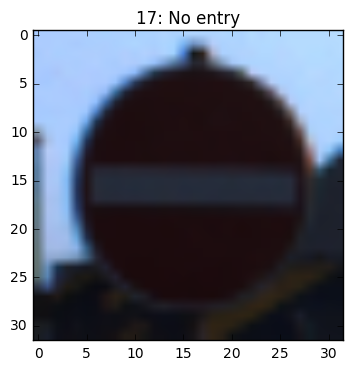

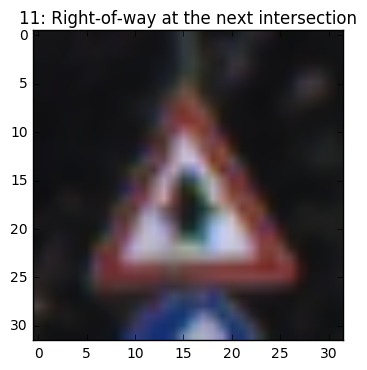

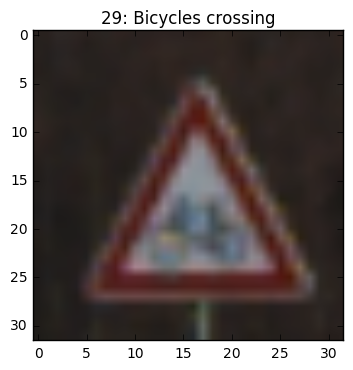

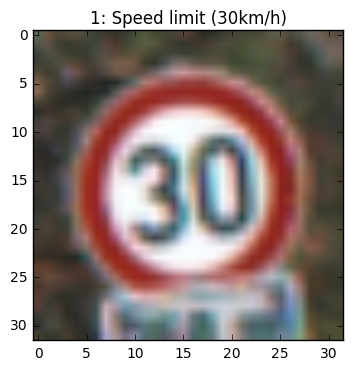

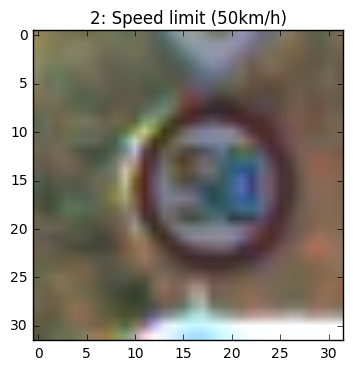

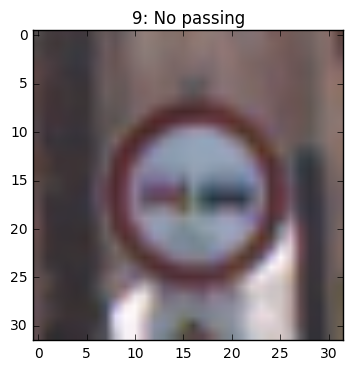

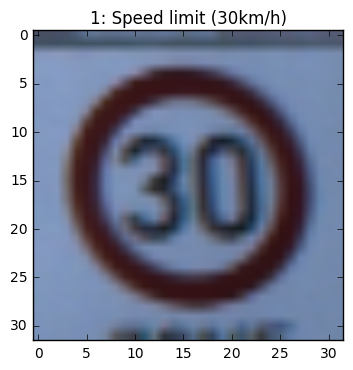

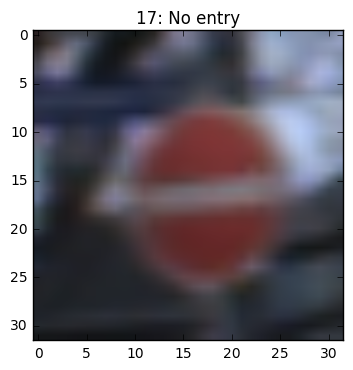

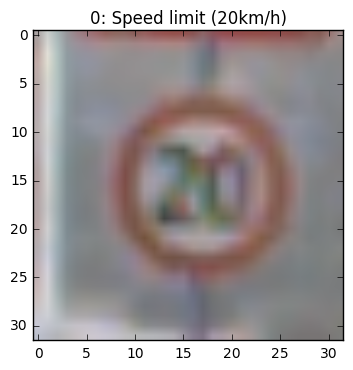

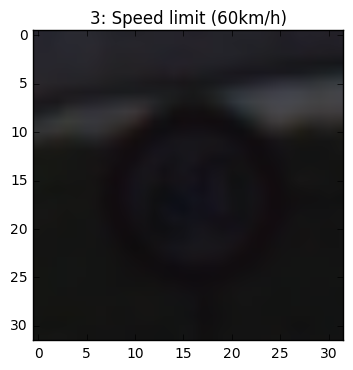

In [11]:
from collections import Counter
from csv import DictReader
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
def view(X, y, cnt=10, type=None):
    sign_codes = read_sign_codes()
    local_data = list(zip(X,y))
    if type != None:
        local_data = [v for v in local_data if v[1] == type]
    for i in range(cnt):
        index = random.randint(0, len(local_data))
        image = local_data[index][0].squeeze()
        
        plt.figure(i)
        plt.title("{0}: {1}".format(local_data[index][1],sign_codes[str(local_data[index][1])]))
        if len(image.shape)==2:
            plt.imshow(image, cmap="gray")
        else:
            plt.imshow(image)
    
    plt.show()


data_cnts = Counter()
for y in y_train:
    data_cnts[y] += 1

sign_codes = read_sign_codes()
for code in sign_codes.keys():
    print("{0:>3}: {1:50} {2:5}".format(code, sign_codes[code], data_cnts[int(code)]))

print("\nTotal classes: {0}".format(len(sign_codes)))

print("\n\n 10 Sample Images from the training data set")
view(X_train, y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Preprocessing is done in the data loading sections above.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_



**Answer:**


### Data Sets
I processed the raw data into several different versions of the data. I used all versions of the input data for model evaluation. The data sets generated are described below:

|Data Set|Description|
|--|--|
|**data**|the raw, unmodified data.|
|**data_yuv**|the `data` converted to the YUV color scheme with the Y channel standardized (centered on its mean and scaled by the inverse of its standard deviation); U and V channels are left unchanged. This was inspired by Sermanet and LeCun paper.|
|**data_yuv_rotate**|the `data_yuv` data, plus the same data rotated/shifted/scaled as described below.|
|**data_greyscale**|the Y channel of the `data_yuv` data.|
|**data_greyscale_rotate**|the `data_greyscale`, plus the same data rotated/shifted/scaled as described below.|

### Jittered Data
The data sets with names ending in "\_rotate" were augmented by applying an image adjustment to each image and adding it to the data set 2 times. Thus for every input image, two jittered images where added. The adjustment randomly shifts, scales and rotates the images; the shift was [-2,2] pixels in both the x and y axes; the scaling factor is [0.9,1.1] and the rotating factor is [-15,15] degrees.

### Reasoning
I wanted to evaluate the model on several different data sets to see if any one of them had an advantage in terms of the ability to distinguish signs.

The data were converted to the YUV color scheme to see if this representation provided any additional distinguishing value.

The greyscale-only channel was considered to see if it alone contained the explanatory value in the model. If so, this should lessen the computational needs of fitting the model.

The data were agumented with jittered data to help make the model more robust to position and angle of the sign in the image. This was inspired by Sermanet and LeCun paper.


In [5]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Generated data is done in the data loading code above.
### Data is split into training/validation sets in the fit method below

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I used SciKitLearn's StratifiedShuffleSplit to split the provided training set into training and validation sets. I reserved 20% of the training set for validation. The StratifiedShuffleSplit ensures that the validation and training sets contain a proportion of each label roughly equal to the label's proportion in the training set.

I reserved the test data set provided for the final test of the model prior to submission.

\[Generated data is described in the answer to question 1 above.\]

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
def conv2d(x, W, b, strides=1,padding='VALID'):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2, padding='SAME'):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def LeNet_dropout(x, keep_prob):
    '''
    Straight LeNet from the lab.
    '''   
    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    num_channels = x.get_shape()[3].value
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    w1 = tf.Variable(tf.truncated_normal([5,5,num_channels,6],stddev=sigma))
    b1 = tf.Variable(tf.zeros(6))
    conv1 = conv2d(x, w1, b1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1)
    conv1 = tf.nn.dropout(conv1, keep_prob)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    w2 = tf.Variable(tf.truncated_normal([5,5,6,16],stddev=sigma))
    b2 = tf.Variable(tf.zeros(16))
    conv2 = conv2d(conv1, w2, b2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2)

    # Flatten. Input = 5x5x16. Output = 400.
    flattened_size = 5*5*16
    fc1 = tf.reshape(conv2, [-1, flattened_size])
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    w3 = tf.Variable(tf.truncated_normal([flattened_size, 120],stddev=sigma))
    b3 = tf.Variable(tf.zeros(120))
    fc1 = tf.add(tf.matmul(fc1,w3),b3)
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    w4 = tf.Variable(tf.truncated_normal([120, 84],stddev=sigma))
    b4 = tf.Variable(tf.zeros(84))
    fc2 = tf.add(tf.matmul(fc1,w4),b4)
    fc2 = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    w5 = tf.Variable(tf.truncated_normal([84, 43],stddev=sigma))
    b5 = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(fc2,w5),b5, name="logits")

    return logits



### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

### Architecture

The architecture of my chosen model is the LeNet architecture presented in the TensorFlow lab with added dropout steps. The model includes the layers described in the following table. The dropouts were added between the first max pooling layer and second convolution layer, and between the first and second fully connected layers.

|Layer|Input Dimensions|Output Dimensions|
|-|-|-|
|5x5 convolution|32x32x1|28x28x6|
|2x2 max pooling|28x28x6|14x14x6|
|5x5 convolution|14x14x6|10x10x16|
|2x2 max pooling|10x10x16|5x5x16|
|Fully connected|400|120|
|Fully connected|120|43|


In [7]:
### Train your model here.
### Feel free to use as many code cells as needed.
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from csv import DictWriter
from datetime import datetime
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
import time

def run_fit(load_data, model, epochs=100, batch_size=128, learning_rate=0.001, 
            write_results=False, evaluate_test_set=False):
    '''
    Execute a model fit using the data, model and parameters provided.
    '''
    start_time = time.time()
    
    X_train_o, y_train_o, X_test_o, y_test_o = load_data()
    
    # split the training data into training/validation sets
    splitter = StratifiedShuffleSplit(y_train_o, n_iter=1, test_size=0.2)
    for train_index, validation_index in splitter:
        X_train = X_train_o[train_index]
        y_train = y_train_o[train_index]
        X_validation = X_train_o[validation_index]
        y_validation = y_train_o[validation_index]
    
    
    assert(len(X_train) == len(y_train))
    assert(len(X_validation) == len(y_validation))
    
    print()
    print("Data Source:    {}".format(load_data.__name__))
    print("Model:          {}".format(model.__name__))
    print("Image Shape:    {}".format(X_train[0].shape))
    print("Learning Rate:  {}".format(learning_rate))
    print("Epochs:         {}".format(epochs))
    print("Batch Size:     {}".format(batch_size))
    print("Training Set:   {} samples".format(len(X_train)))
    print("Test Set:       {} samples".format(len(X_validation)))
        
    X_train, y_train = shuffle(X_train, y_train)

    x = tf.placeholder(tf.float32, (None, X_train[0].shape[0], X_train[0].shape[1], X_train[0].shape[2]))
    y = tf.placeholder(tf.int32, (None))
    keep_prob = tf.placeholder(tf.float32, (None))
    one_hot_y = tf.one_hot(y, 43)
        
    logits = model(x, keep_prob)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
    training_operation = optimizer.minimize(loss_operation)
    
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    def evaluate(sess, X_data, y_data):
        num_examples = len(X_data)
        total_accuracy = 0
        total_loss = 0
        for offset in range(0, num_examples, batch_size):
            batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
            loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
            total_accuracy += (accuracy * len(batch_x))
            total_loss += (loss*len(batch_x))
        return total_accuracy / num_examples, total_loss / num_examples
    
    max_accuracy = 0.0
    min_loss = 1000000000
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(epochs):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})

        validation_accuracy, loss = evaluate(sess, X_validation, y_validation)
        dobreak = validation_accuracy - max_accuracy < 0.0001
        max_accuracy = np.max([max_accuracy, validation_accuracy])
        min_loss = np.min([min_loss, loss])
        print("EPOCH {}: Accuracy: {:>.4}; Loss: {:>7.4}".format(i+1,validation_accuracy, loss))
        if dobreak:
            break
    print("Done!")
    final_epoch = i+1

    if evaluate_test_set:
        test_accuracy, test_loss = evaluate(sess, X_test_o, y_test_o)
        print("\nTest Accuracy: {:>.4}; Loss {:>7.4}".format(test_accuracy, test_loss))
    
    
    ## sorry, I can't seem to load a saved model, so I need to return these variables for use in prediction
    return sess, logits, x, keep_prob

sess,logits,x,keep_prob = run_fit(data_greyscale_rotate, LeNet_dropout, learning_rate=0.001, batch_size=256, evaluate_test_set=True)


/home/jim/anaconda3/envs/traffic-signs/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



Data Source:    data_greyscale_rotate
Model:          LeNet_dropout
Image Shape:    (32, 32, 1)
Learning Rate:  0.001
Epochs:         100
Batch Size:     256
Training Set:   94101 samples
Test Set:       23526 samples
Training...

EPOCH 1: Accuracy: 0.8253; Loss:  0.6218
EPOCH 2: Accuracy: 0.9052; Loss:   0.348
EPOCH 3: Accuracy: 0.933; Loss:  0.2559
EPOCH 4: Accuracy: 0.9479; Loss:  0.1928
EPOCH 5: Accuracy: 0.956; Loss:   0.164
EPOCH 6: Accuracy: 0.9617; Loss:  0.1408
EPOCH 7: Accuracy: 0.9626; Loss:  0.1273
EPOCH 8: Accuracy: 0.9677; Loss:  0.1091
EPOCH 9: Accuracy: 0.9695; Loss:   0.103
EPOCH 10: Accuracy: 0.9741; Loss: 0.08925
EPOCH 11: Accuracy: 0.9742; Loss: 0.08555
EPOCH 12: Accuracy: 0.9785; Loss: 0.07662
EPOCH 13: Accuracy: 0.9769; Loss: 0.07642
Done!

Test Accuracy: 0.9363; Loss  0.2477


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I used the following settings/values in training the final model.

|Knob|Value/Description|
|--|--|
|Optimizer|I used the AdamOptimizer. This optimizer implements concepts of momentum and lowering the learning rate over time.|
|Batch Size|256|
|Epochs|Instead of training for a fixed number of epochs, the trainer stopped evaluating a model when the increase in accuracy from one epoch to the next fell below 0.0001.|
|Learning Rate|I used a learning rate of 0.001|
|mu,sigma|I used mu=0.0 and sigma=0.1 when generating weights.|
|Keep Probability|I used a keep probability of 0.7 for the training runs.|


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

### Approach
I used an iterative approach to arrive at my final model, generally following these steps:

1. I created and experimented with several models until I settled on four that provided reasonable accuraccy rates. The models are described in the Models section below.
1. I ran all possible combinations of the following (results are show in the Fit Results section at the end of the notebook):
    1. The four models
    2. The five data sets described above
    3. Three learning rates: 0.001, 0.0005, 0.0001
    4. Three batch sizes: 128, 256, 384
1. I analyzed the output from the fit runs in the previous step and decided the following:
    1. I chose to focus on the greyscal_rotate data set. The data sets containing the jittered data outperformed the other data sets and the greyscale_rotate data set is smaller, requires fewer parameters and is faster to fit.
    1. I chose to focus on 2 models: LeNet_dropout and multiscale1. These models both performed quite well.
    2. I decided to proceed with a learning rate of 0.001. The various learning rates did not display a clear difference in results and 0.001 performed well. Further the AdamOptimizer adjusts the learning rate as the model fit proceeds.
    2. I decided to proceed with a batch size of 256. The various batch sizes did not display a clear difference in results and 256 performed well and reduced the fit time over 128.
1. I ran 5 runs with each of the 2 models: LeNet_dropout and multiscale1. The LeNet_dropout model performed slightly better on average (results are shown in the Final Fits section at the end of the notebook).
1. Finally, I introduced stratification based on labels into the creation of the training and validation sets (all previous runs did not use stratified data sets) and ran 5 runs with each of the 2 models (results are shown in the Final Fits section at the end of the notebook). The stratified training/validation sets performed better on average than the non stratified data sets.

After this process, I arrived at the following model, which is reflected in this notebook: 
1. The LeNet_dropout model.
1. The greyscale_rotate data set.
1. Stratified training/validation sets.
    
    
### Models
The models that I evaluated are in the following table:

|Model|Description|
|--|--|
|**LeNet**|The LeNet model exactly as it was used in the lab.|
|**LeNet_dropout**|The LeNet model with dropout. I like the idea of dropout to make the model more robust to overfitting.|
|**inception2**|A model using the inception scheme described in Lession 29 of the lecture on convolutional neural networks. I used this architecture because the concept was presented in class and I wanted to see if I could implement it.|
|**multiscale1**|A model that includes data from multiple scales in the final fully connected layer. This was inspired by Sermanet and LeCun paper on the same data set.|



---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

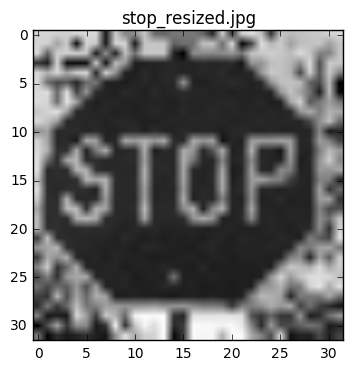

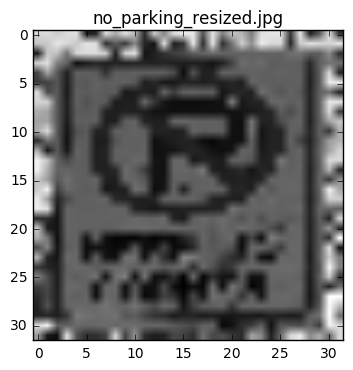

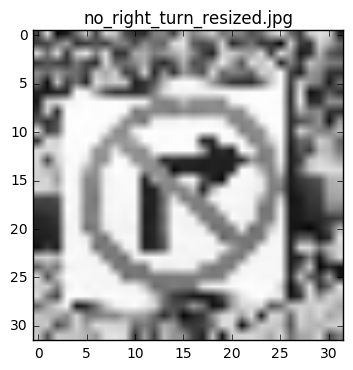

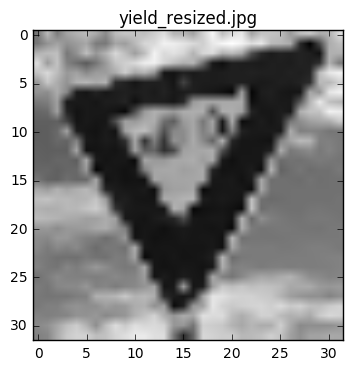

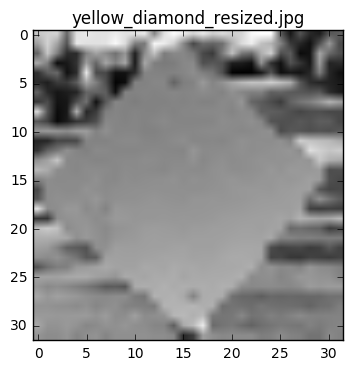

In [8]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
def get_images_to_evaluate():
    return ["stop_resized.jpg","no_parking_resized.jpg","no_right_turn_resized.jpg",
            "yield_resized.jpg","yellow_diamond_resized.jpg"]

def load_image(imagename):
    img = cv2.imread(imagename, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image_names = get_images_to_evaluate()
images = rgb2gray([load_image(data_root+image_name) for image_name in image_names])
for v in zip(image_names,images):
    plt.title(v[0])
    plt.imshow(v[1].squeeze(),cmap='gray')
    plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

The 5 images I have chosen are signs in my local area of Des Moines, IA, US. They are:

|Image|Class in Training Set| 
|-|-|
|stop_resized.jpg|14|
|no_parking_resized.jpg|Not in training set|
|no_right_turn_resized.jpg|Not in training set|
|yield_resized.jpg|13|
|yellow_diamond_resized.jpg|Not in training set; close to class 12 (Priority Road)|


For the 2 signs not present in the training set, the classifier will not be able to correctly predict the class because the correct class does not exist. For the the yellow_diamond_resized.jpg, I would expect the model to strongly favor class 12 because it is very similar.

My assumption is that the 2 cases in which the signs do not resemble classes in the training set, the probabilities will display a high degree of uncertainty. That is, no particular class will be given a high probability and many will be given a low probability.




Image Analyzed: stop_resized.jpg


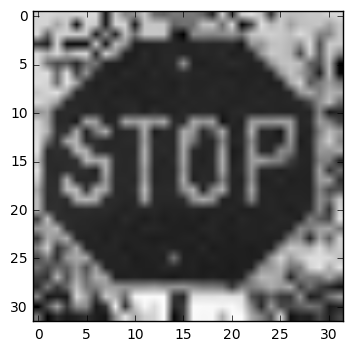

Class                          : Probability
  14: Stop                     :     1.0


Sample images for matching class...


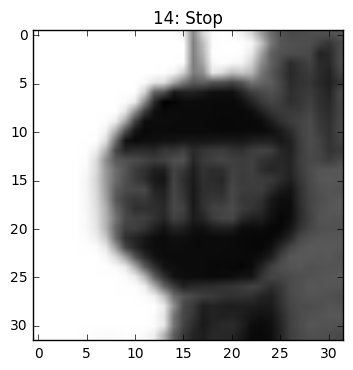

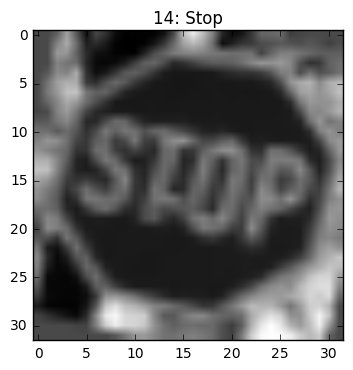

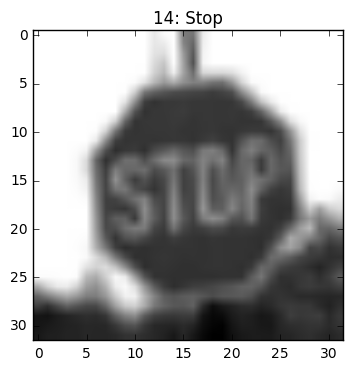

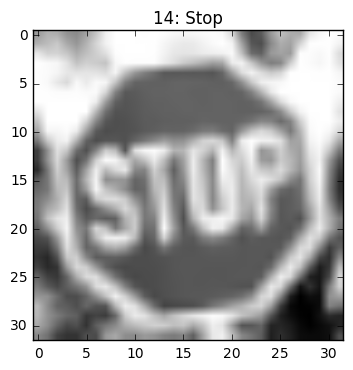

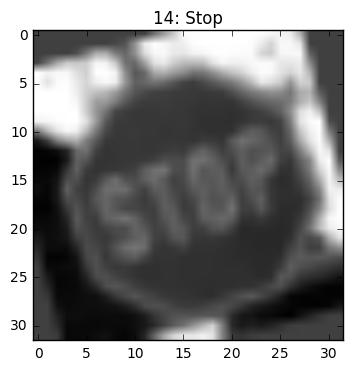




Image Analyzed: no_parking_resized.jpg


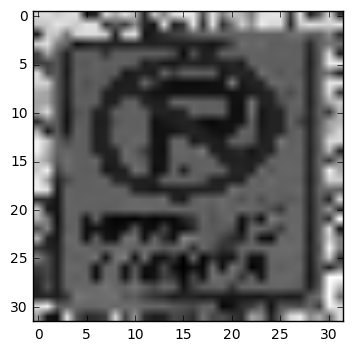

Class                          : Probability
  38: Keep right               : 0.999674
  25: Road work                : 0.000325934
  14: Stop                     : 5.43893e-32


Sample images for matching class...


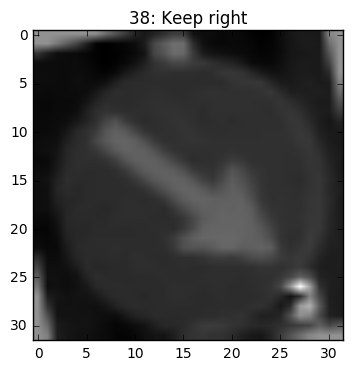

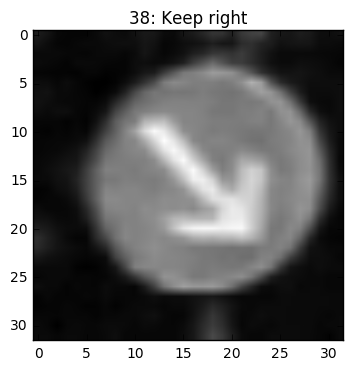

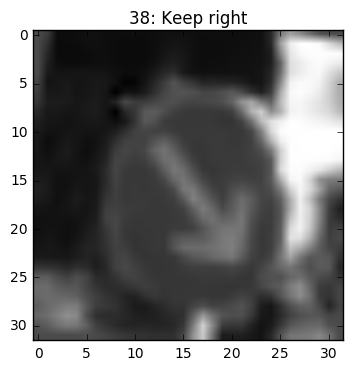

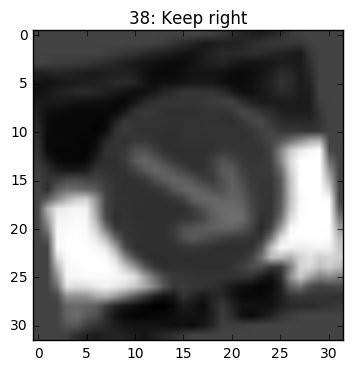

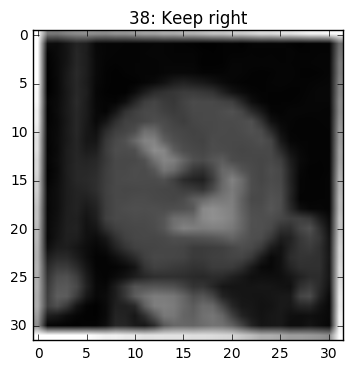




Image Analyzed: no_right_turn_resized.jpg


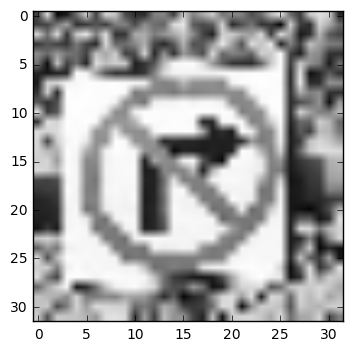

Class                          : Probability
   0: Speed limit (20km/h)     :     1.0


Sample images for matching class...


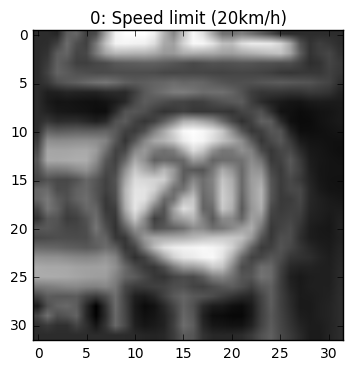

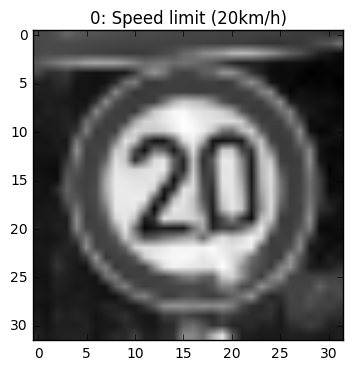

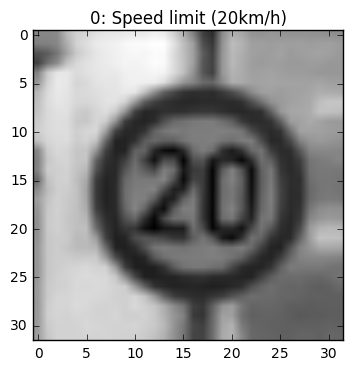

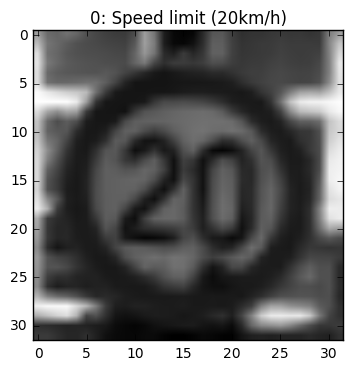

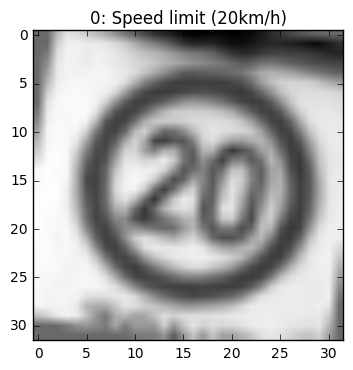




Image Analyzed: yield_resized.jpg


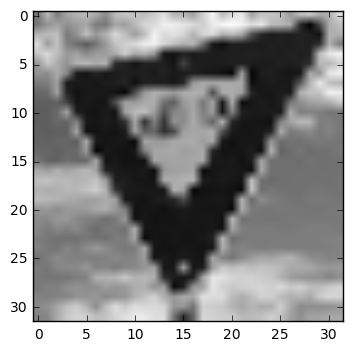

Class                          : Probability
  13: Yield                    :     1.0


Sample images for matching class...


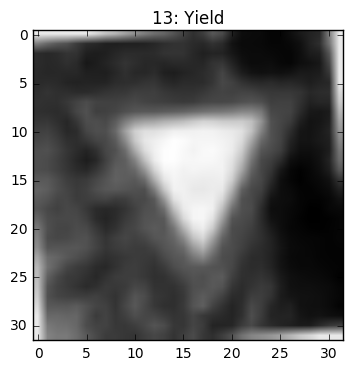

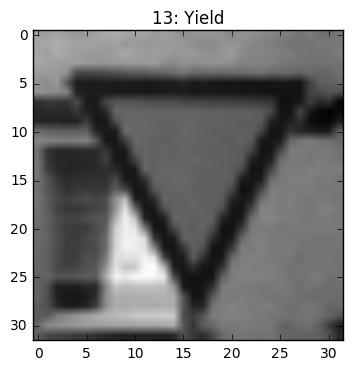

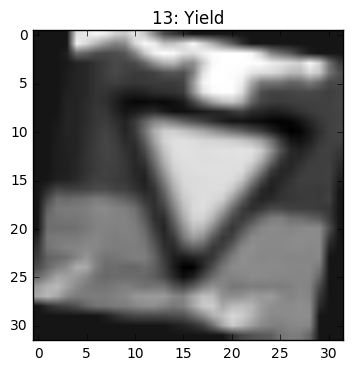

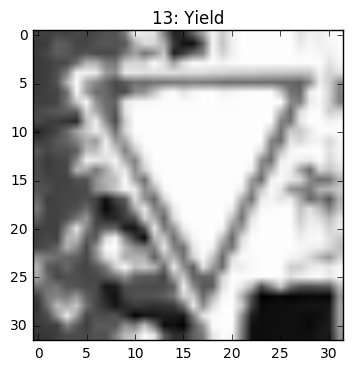

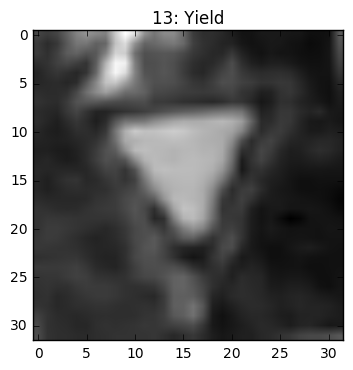




Image Analyzed: yellow_diamond_resized.jpg


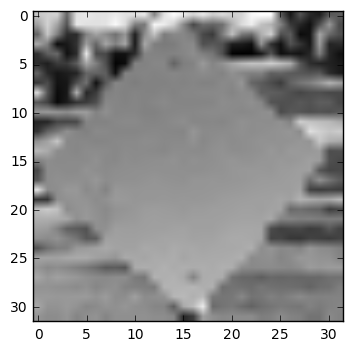

Class                          : Probability
  12: Priority road            :     1.0
  38: Keep right               : 2.7549e-09
  41: End of no passing        : 8.65996e-24
  42: End of no passing by vehicles over 3.5 metric tons: 1.30672e-24
  40: Roundabout mandatory     : 1.95007e-33


Sample images for matching class...


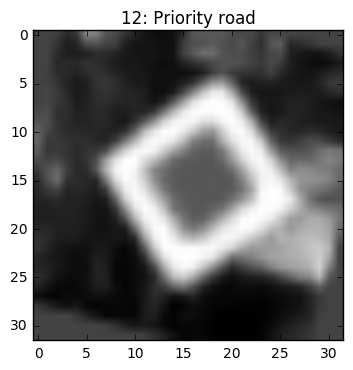

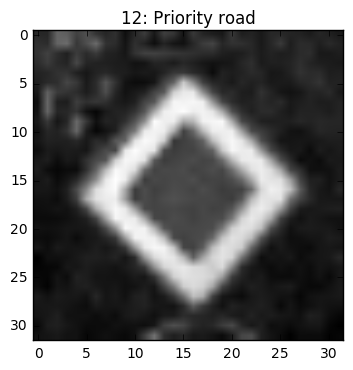

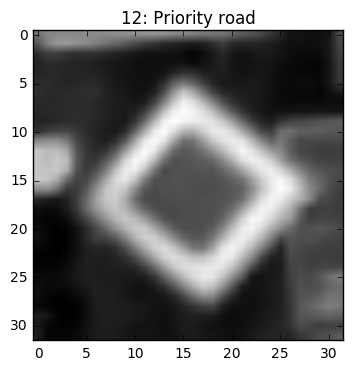

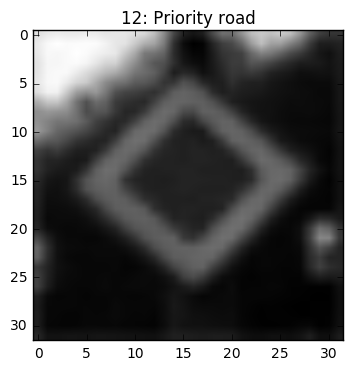

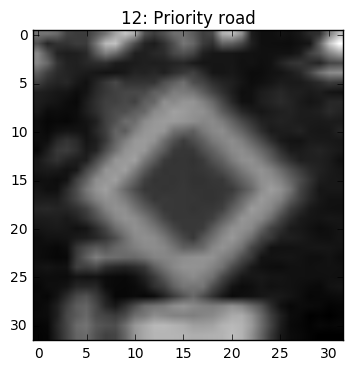

In [12]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

probs = tf.nn.softmax(logits)
result_probs = sess.run(probs, feed_dict={x: images, keep_prob: 1.0})
X,y,_,_ = data_greyscale_rotate()
for i in range(len(image_names)):
    print("\n\n\n"+"="*75)
    print("Image Analyzed: {}".format(image_names[i]))
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.show()
    pbs = result_probs[i]
    pbs_index = zip(range(len(pbs)), pbs)
    sorted_pbs = sorted(pbs_index, key=lambda pb: -pb[1])
    print("{:31}: {}".format("Class","Probability"))
    
    for i in range(5):
        v = sorted_pbs[i]
        if v[1] > 0.0:
            print("{:>4}: {:25}: {:7.6}".format(v[0],sign_codes[str(v[0])],v[1]))

    print("\n\nSample images for matching class...")
    view(X,y,5,sorted_pbs[0][0])

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In the results above, for each image I printed out:

1. the image being classified, 
1. the top 5 probability values that are greater than 0, and 
1. 5 sample images from the class with the greatest probability.

For the 3 images that had corresponding classes in the training set (or very similar classes) the model correctly classified the images. From this perspective, the model worked as I expected.

For the 2 images that were not in the training set, I was surprised to see that there was very little uncertainty expressed by the probabilities. In fact, for several images I evaluated, only a single class had a probability greater than 0 even when it didn't correctly classify the image. 

From a practical perspective, this seems to be of very limited use. If I feel very confident about my prediction when it's wrong, that doesn't help me make decisions. Instead, I would rather feel quite uncertain about my prediction when it's wrong so I know I'm not sure what sign I'm seeing.

(I'm not sure if I did something wrong in my modeling or if this is the way these models behave, but this is quite perplexing.)

In [10]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

See the output above.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Fit Results

The results of these runs are provided in the following table, ordered by accuracy.

|Date|Data Source|Model|Epochs|Batch Size|Learning Rate|Max Accuracy|Min Loss|Time (s)|Training Samples|Test Samples|
|--|--|--|--|--|--|--|--|--|--|--|
|Date|Data Source|Model|Epochs|Batch Size|Learning Rate|Max Accuracy|Min Loss|Time (s)|Training Samples|Test Samples|
|2016-12-28 21:23:56.023956|data_greyscale_rotate|LeNet|11|256|0.001|0.9793|0.0483|89.6|94101|23526|
|2016-12-28 21:53:47.703829|data_greyscale_rotate|multiscale1|10|128|0.001|0.9791|0.0319|97.5|94101|23526|
|2016-12-28 13:27:49.883531|data_yuv_rotate|LeNet_dropout|14|256|0.001|0.9784|0.0775|174|94101|23526|
|2016-12-28 21:33:56.411145|data_greyscale_rotate|LeNet_dropout|12|128|0.001|0.9769|0.116|118|94101|23526|
|2016-12-29 06:28:43.131337|data_greyscale_rotate|inception2|9|256|0.001|0.9769|0.104|309|94101|23526|
|2016-12-28 13:09:19.425577|data_yuv_rotate|LeNet|17|384|0.0005|0.9768|0.034|195|94101|23526|
|2016-12-28 22:03:55.322411|data_greyscale_rotate|multiscale1|9|384|0.001|0.975|0.169|74|94101|23526|
|2016-12-28 21:55:16.964759|data_greyscale_rotate|multiscale1|9|128|0.0005|0.9746|0.0953|89.2|94101|23526|
|2016-12-28 22:00:27.958019|data_greyscale_rotate|multiscale1|11|256|0.0005|0.974|0.121|90.6|94101|23526|
|2016-12-28 13:42:16.280155|data_yuv_rotate|LeNet_dropout|18|384|0.001|0.9731|0.0887|212|94101|23526|
|2016-12-28 21:35:45.507734|data_greyscale_rotate|LeNet_dropout|11|128|0.0005|0.9727|0.0832|109|94101|23526|
|2016-12-28 12:56:33.040563|data_yuv_rotate|LeNet|8|256|0.001|0.9725|0.078|105|94101|23526|
|2016-12-28 21:18:46.960575|data_greyscale_rotate|LeNet|6|128|0.001|0.9722|0.0504|63.8|94101|23526|
|2016-12-28 13:15:34.011718|data_yuv_rotate|LeNet_dropout|11|128|0.001|0.972|0.135|160|94101|23526|
|2016-12-28 13:58:07.546892|data_yuv_rotate|multiscale1|12|128|0.0005|0.9716|0.0582|169|94101|23526|
|2016-12-28 14:57:56.938738|data_yuv_rotate|inception2|9|128|0.0005|0.9713|0.199|615|94101|23526|
|2016-12-28 21:46:31.610362|data_greyscale_rotate|LeNet_dropout|10|384|0.001|0.9713|0.194|82.1|94101|23526|
|2016-12-28 13:32:28.107745|data_yuv_rotate|LeNet_dropout|19|256|0.0005|0.9696|0.131|278|94101|23526|
|2016-12-28 21:39:51.500948|data_greyscale_rotate|LeNet_dropout|11|256|0.001|0.9687|0.14|93|94101|23526|
|2016-12-28 17:25:28.395542|data_yuv|LeNet_dropout|30|384|0.001|0.9677|0.0604|105|31367|7842|
|2016-12-28 16:03:53.921058|data_yuv_rotate|inception2|13|128|0.0001|0.9674|0.3|852|94101|23526|
|2016-12-28 15:49:41.570041|data_yuv_rotate|inception2|8|128|0.0005|0.9672|0.0615|525|94101|23526|
|2016-12-28 14:09:18.953138|data_yuv_rotate|multiscale1|10|256|0.0005|0.967|0.141|129|94101|23526|
|2016-12-28 21:28:27.477455|data_greyscale_rotate|LeNet|8|384|0.001|0.967|0.188|65.5|94101|23526|
|2016-12-28 21:58:57.271641|data_greyscale_rotate|multiscale1|6|256|0.001|0.9666|0.142|55.4|94101|23526|
|2016-12-29 06:14:33.169607|data_greyscale_rotate|inception2|6|128|0.001|0.9665|0.0781|241|94101|23526|
|2016-12-28 12:54:47.985070|data_yuv_rotate|LeNet|17|128|0.0001|0.9664|0.0296|251|94101|23526|
|2016-12-28 17:04:30.305470|data_yuv|LeNet|8|128|0.001|0.9653|0.223|36.8|31367|7842|
|2016-12-28 13:55:18.018832|data_yuv_rotate|multiscale1|6|128|0.001|0.9651|0.0897|94.7|94101|23526|
|2016-12-28 12:49:16.326896|data_yuv_rotate|LeNet|5|128|0.001|0.9648|0.234|108|94101|23526|
|2016-12-28 17:10:51.728688|data_yuv|LeNet|11|384|0.001|0.9631|0.0602|41.5|31367|7842|
|2016-12-28 21:41:24.497566|data_greyscale_rotate|LeNet_dropout|11|256|0.0005|0.9629|0.154|93|94101|23526|
|2016-12-28 15:40:56.658914|data_yuv_rotate|inception2|5|128|0.001|0.9626|0.105|335|94101|23526|
|2016-12-29 06:17:59.941392|data_greyscale_rotate|inception2|5|128|0.0005|0.9626|0.0544|207|94101|23526|
|2016-12-28 12:50:36.496261|data_yuv_rotate|LeNet|5|128|0.0005|0.9614|0.0786|80|94101|23526|
|2016-12-28 17:34:25.628865|data_yuv|multiscale1|18|256|0.001|0.9611|0.229|68.8|31367|7842|
|2016-12-28 12:42:45.589573|data|inception2|15|384|0.001|0.9602|0.121|292|31367|7842|
|2016-12-28 21:25:17.444118|data_greyscale_rotate|LeNet|10|256|0.0005|0.9598|0.102|81.4|94101|23526|
|2016-12-28 13:19:02.931248|data_yuv_rotate|LeNet_dropout|11|128|0.0005|0.9594|0.149|209|94101|23526|
|2016-12-28 14:47:41.540665|data_yuv_rotate|inception2|6|128|0.001|0.9592|0.235|424|94101|23526|
|2016-12-28 13:04:53.624131|data_yuv_rotate|LeNet|27|256|0.0001|0.959|0.3|358|94101|23526|
|2016-12-28 16:11:56.371684|data_yuv_rotate|inception2|8|256|0.001|0.959|0.124|482|94101|23526|
|2016-12-28 21:48:08.039647|data_greyscale_rotate|LeNet_dropout|12|384|0.0005|0.9584|0.149|96.4|94101|23526|
|2016-12-28 12:58:55.722333|data_yuv_rotate|LeNet|8|256|0.0005|0.9583|0.246|143|94101|23526|
|2016-12-28 13:45:50.537330|data_yuv_rotate|LeNet_dropout|18|384|0.0005|0.9582|0.132|214|94101|23526|
|2016-12-28 14:07:09.678925|data_yuv_rotate|multiscale1|11|256|0.001|0.9578|0.154|173|94101|23526|
|2016-12-29 06:32:19.813649|data_greyscale_rotate|inception2|6|256|0.0005|0.9574|0.154|217|94101|23526|
|2016-12-28 14:19:02.441325|data_yuv_rotate|multiscale1|9|384|0.001|0.957|0.126|115|94101|23526|
|2016-12-28 22:05:03.069509|data_greyscale_rotate|multiscale1|8|384|0.0005|0.9566|0.116|67.7|94101|23526|
|2016-12-29 06:43:13.833207|data_greyscale_rotate|inception2|5|384|0.001|0.9566|0.367|179|94101|23526|
|2016-12-28 14:04:16.339062|data_yuv_rotate|multiscale1|28|128|0.0001|0.9563|0.171|369|94101|23526|
|2016-12-28 17:14:58.678377|data_yuv|LeNet_dropout|11|128|0.001|0.9559|0.193|47.7|31367|7842|
|2016-12-28 17:39:48.697251|data_yuv|multiscale1|15|384|0.001|0.9543|0.111|58.4|31367|7842|
|2016-12-28 21:29:46.216494|data_greyscale_rotate|LeNet|10|384|0.0005|0.9543|0.138|78.7|94101|23526|
|2016-12-28 18:34:12.587577|data_greyscale|LeNet_dropout|23|128|0.0005|0.954|0.268|71.9|31367|7842|
|2016-12-28 11:42:00.644688|data|LeNet|15|256|0.0005|0.9538|0.421|51.1|31367|7842|
|2016-12-28 18:39:35.436605|data_greyscale|LeNet_dropout|26|384|0.001|0.9536|0.184|67.5|31367|7842|
|2016-12-28 17:35:51.866388|data_yuv|multiscale1|23|256|0.0005|0.9532|0.0457|86.2|31367|7842|
|2016-12-28 18:45:25.081996|data_greyscale|multiscale1|13|256|0.001|0.9531|0.153|39.4|31367|7842|
|2016-12-28 21:19:40.839062|data_greyscale_rotate|LeNet|5|128|0.0005|0.953|0.0959|53.9|94101|23526|
|2016-12-28 13:06:04.123990|data_yuv_rotate|LeNet|5|384|0.001|0.9524|0.155|70.4|94101|23526|
|2016-12-28 16:57:34.085111|data_yuv_rotate|inception2|14|384|0.0001|0.9522|0.205|847|94101|23526|
|2016-12-28 18:27:44.855972|data_greyscale|LeNet|13|256|0.0005|0.9518|0.529|37.5|31367|7842|
|2016-12-28 21:22:26.423177|data_greyscale_rotate|LeNet|18|128|0.0001|0.9517|0.224|166|94101|23526|
|2016-12-28 17:50:32.175938|data_yuv|inception2|7|128|0.0005|0.9505|0.29|161|31367|7842|
|2016-12-28 18:33:00.598716|data_greyscale|LeNet_dropout|14|128|0.001|0.9501|0.0586|46.5|31367|7842|
|2016-12-28 18:26:39.493758|data_greyscale|LeNet|29|128|0.0001|0.948|0.0989|84.9|31367|7842|
|2016-12-29 06:40:14.688799|data_greyscale_rotate|inception2|13|256|0.0001|0.9479|0.165|475|94101|23526|
|2016-12-28 18:25:14.498567|data_greyscale|LeNet|11|128|0.0005|0.9468|0.184|37|31367|7842|
|2016-12-28 11:38:22.482156|data|LeNet|11|128|0.0005|0.9463|0.243|44|31367|7842|
|2016-12-28 17:30:56.088528|data_yuv|multiscale1|23|128|0.0005|0.9459|0.0492|95.1|31367|7842|
|2016-12-28 21:58:01.860776|data_greyscale_rotate|multiscale1|18|128|0.0001|0.9452|0.158|165|94101|23526|
|2016-12-29 06:46:49.059147|data_greyscale_rotate|inception2|6|384|0.0005|0.9445|0.211|215|94101|23526|
|2016-12-28 22:08:11.842830|data_greyscale_rotate|multiscale1|26|384|0.0001|0.9441|0.167|189|94101|23526|
|2016-12-28 14:40:37.621001|data_yuv_rotate|multiscale1|34|384|0.0001|0.9435|0.152|1180|94101|23526|
|2016-12-28 21:45:09.499349|data_greyscale_rotate|LeNet_dropout|29|256|0.0001|0.9428|0.173|225|94101|23526|
|2016-12-28 17:57:44.977505|data_yuv|inception2|11|256|0.001|0.9427|0.31|228|31367|7842|
|2016-12-28 17:27:03.984641|data_yuv|LeNet_dropout|27|384|0.0005|0.9424|0.236|95.6|31367|7842|
|2016-12-28 14:20:58.148409|data_yuv_rotate|multiscale1|9|384|0.0005|0.9418|0.286|116|94101|23526|
|2016-12-28 14:17:07.108923|data_yuv_rotate|multiscale1|32|256|0.0001|0.9417|0.21|468|94101|23526|
|2016-12-29 06:23:34.391980|data_greyscale_rotate|inception2|8|128|0.0001|0.9414|0.16|334|94101|23526|
|2016-12-28 18:36:25.085514|data_greyscale|LeNet_dropout|18|256|0.001|0.941|0.246|51.7|31367|7842|
|2016-12-28 11:40:25.835393|data|LeNet|31|128|0.0001|0.9408|0.598|123|31367|7842|
|2016-12-28 11:41:09.556918|data|LeNet|13|256|0.001|0.9402|0.201|43.7|31367|7842|
|2016-12-28 16:32:15.117819|data_yuv_rotate|inception2|13|256|0.0001|0.9399|0.247|789|94101|23526|
|2016-12-28 17:29:20.968844|data_yuv|multiscale1|12|128|0.001|0.9399|0.047|54|31367|7842|
|2016-12-28 17:05:06.228359|data_yuv|LeNet|8|128|0.0005|0.9394|0.016|35.9|31367|7842|
|2016-12-28 18:17:33.459295|data_yuv|inception2|16|384|0.0005|0.9394|0.354|323|31367|7842|
|2016-12-28 17:11:36.580774|data_yuv|LeNet|12|384|0.0005|0.9393|0.121|44.8|31367|7842|
|2016-12-28 18:29:32.812727|data_greyscale|LeNet|43|256|0.0001|0.9392|0.201|108|31367|7842|
|2016-12-28 18:12:10.487474|data_yuv|inception2|8|384|0.001|0.938|0.228|165|31367|7842|
|2016-12-28 17:20:21.892756|data_yuv|LeNet_dropout|17|256|0.001|0.9379|0.266|64.8|31367|7842|
|2016-12-28 12:07:42.201220|data|multiscale1|18|256|0.001|0.9369|0.299|62|31367|7842|
|2016-12-28 18:27:07.281341|data_greyscale|LeNet|9|256|0.001|0.9364|0.268|27.7|31367|7842|
|2016-12-28 17:07:04.447400|data_yuv|LeNet|8|256|0.001|0.936|0.184|33.3|31367|7842|
|2016-12-28 12:01:49.599532|data|multiscale1|15|128|0.001|0.9348|0.0888|61.9|31367|7842|
|2016-12-28 18:30:34.655886|data_greyscale|LeNet|13|384|0.0005|0.9342|0.169|36.4|31367|7842|
|2016-12-28 18:01:14.148983|data_yuv|inception2|10|256|0.0005|0.9332|0.204|209|31367|7842|
|2016-12-28 12:09:03.614470|data|multiscale1|24|256|0.0005|0.932|0.232|81.4|31367|7842|
|2016-12-28 13:12:53.683640|data_yuv_rotate|LeNet|18|384|0.0001|0.9317|0.132|214|94101|23526|
|2016-12-28 22:02:41.245654|data_greyscale_rotate|multiscale1|17|256|0.0001|0.9316|0.358|133|94101|23526|
|2016-12-28 17:06:31.183569|data_yuv|LeNet|21|128|0.0001|0.9311|0.158|84.9|31367|7842|
|2016-12-28 17:47:50.881548|data_yuv|inception2|10|128|0.001|0.9311|0.199|225|31367|7842|
|2016-12-28 18:40:45.800779|data_greyscale|LeNet_dropout|27|384|0.0005|0.931|0.266|70.2|31367|7842|
|2016-12-28 17:41:10.333045|data_yuv|multiscale1|22|384|0.0005|0.9308|0.362|81.6|31367|7842|
|2016-12-28 11:53:43.206266|data|LeNet_dropout|20|256|0.001|0.9305|0.3|69.5|31367|7842|
|2016-12-28 12:10:31.727157|data|multiscale1|23|384|0.001|0.9287|0.436|75.1|31367|7842|
|2016-12-28 17:07:41.215118|data_yuv|LeNet|9|256|0.0005|0.9283|0.213|36.8|31367|7842|
|2016-12-28 18:41:36.772675|data_greyscale|multiscale1|9|128|0.001|0.9267|0.209|32.9|31367|7842|
|2016-12-28 18:29:58.126995|data_greyscale|LeNet|8|384|0.001|0.9253|0.194|25.2|31367|7842|
|2016-12-28 17:10:10.195767|data_yuv|LeNet|42|256|0.0001|0.9235|0.234|149|31367|7842|
|2016-12-28 18:47:34.112490|data_greyscale|multiscale1|16|384|0.001|0.9231|0.253|44.6|31367|7842|
|2016-12-28 21:52:10.176653|data_greyscale_rotate|LeNet_dropout|33|384|0.0001|0.9231|0.289|242|94101|23526|
|2016-12-28 17:21:43.372881|data_yuv|LeNet_dropout|22|256|0.0005|0.9229|0.239|81.5|31367|7842|
|2016-12-28 17:14:10.923192|data_yuv|LeNet|46|384|0.0001|0.9225|0.269|154|31367|7842|
|2016-12-28 16:19:05.697416|data_yuv_rotate|inception2|7|256|0.0005|0.9224|0.228|429|94101|23526|
|2016-12-28 21:38:18.513094|data_greyscale_rotate|LeNet_dropout|16|128|0.0001|0.9218|0.27|153|94101|23526|
|2016-12-28 11:44:38.572786|data|LeNet|15|384|0.001|0.9217|0.32|50.3|31367|7842|
|2016-12-28 13:24:55.535866|data_yuv_rotate|LeNet_dropout|23|128|0.0001|0.92|0.349|352|94101|23526|
|2016-12-28 18:48:50.589775|data_greyscale|multiscale1|30|384|0.0005|0.9184|0.367|76.3|31367|7842|
|2016-12-28 21:27:21.981704|data_greyscale_rotate|LeNet|16|256|0.0001|0.9172|0.344|125|94101|23526|
|2016-12-28 11:37:38.516052|data|LeNet|11|128|0.001|0.9162|0.194|44.7|31367|7842|
|2016-12-28 18:42:48.260766|data_greyscale|multiscale1|23|128|0.0005|0.9156|0.18|71.4|31367|7842|
|2016-12-28 13:38:43.697647|data_yuv_rotate|LeNet_dropout|32|256|0.0001|0.9149|0.321|375|94101|23526|
|2016-12-28 18:32:13.969238|data_greyscale|LeNet|41|384|0.0001|0.9149|0.367|99.2|31367|7842|
|2016-12-28 16:37:20.659239|data_yuv_rotate|inception2|5|384|0.001|0.9148|0.452|306|94101|23526|
|2016-12-28 18:44:45.502514|data_greyscale|multiscale1|40|128|0.0001|0.9142|0.494|117|31367|7842|
|2016-12-28 12:31:38.512634|data|inception2|13|256|0.001|0.9139|0.175|259|31367|7842|
|2016-12-28 11:45:19.019501|data|LeNet|12|384|0.0005|0.9138|0.287|40.4|31367|7842|
|2016-12-28 17:33:16.811970|data_yuv|multiscale1|35|128|0.0001|0.9119|0.324|141|31367|7842|
|2016-12-28 17:53:56.838910|data_yuv|inception2|9|128|0.0001|0.9104|0.458|205|31367|7842|
|2016-12-28 18:46:34.994448|data_greyscale|multiscale1|26|256|0.0005|0.9091|0.288|69.8|31367|7842|
|2016-12-28 18:24:37.462270|data_greyscale|LeNet|5|128|0.001|0.9074|0.221|21.1|31367|7842|
|2016-12-28 18:24:16.281127|data_yuv|inception2|20|384|0.0001|0.9063|0.469|403|31367|7842|
|2016-12-28 12:03:17.002424|data|multiscale1|21|128|0.0005|0.9059|0.239|87.4|31367|7842|
|2016-12-28 21:31:58.409479|data_greyscale_rotate|LeNet|18|384|0.0001|0.9052|0.464|132|94101|23526|
|2016-12-28 18:09:25.854773|data_yuv|inception2|24|256|0.0001|0.9044|0.376|492|31367|7842|
|2016-12-28 11:43:48.247329|data|LeNet|32|256|0.0001|0.9036|0.528|108|31367|7842|
|2016-12-28 16:43:27.513557|data_yuv_rotate|inception2|6|384|0.0005|0.9024|0.256|367|94101|23526|
|2016-12-28 13:53:43.083155|data_yuv_rotate|LeNet_dropout|42|384|0.0001|0.9021|0.316|472|94101|23526|
|2016-12-28 11:48:02.483597|data|LeNet|50|384|0.0001|0.8945|0.485|163|31367|7842|
|2016-12-29 00:48:21.232977|data_greyscale|inception2|16|256|0.001|0.8939|0.683|187|31367|7842|
|2016-12-28 17:38:50.298636|data_yuv|multiscale1|50|256|0.0001|0.8911|0.352|178|31367|7842|
|2016-12-28 17:44:06.101726|data_yuv|multiscale1|50|384|0.0001|0.8822|0.399|176|31367|7842|
|2016-12-28 18:37:11.671455|data_greyscale|LeNet_dropout|16|256|0.0005|0.8813|0.413|46.5|31367|7842|
|2016-12-28 11:56:35.753889|data|LeNet_dropout|19|384|0.001|0.8761|0.459|63.7|31367|7842|
|2016-12-28 17:15:59.152883|data_yuv|LeNet_dropout|14|128|0.0005|0.8754|0.479|60.5|31367|7842|
|2016-12-28 12:19:03.087973|data|inception2|16|128|0.0005|0.8669|0.628|341|31367|7842|
|2016-12-29 06:50:33.017081|data_greyscale_rotate|inception2|6|384|0.0001|0.8669|0.403|224|94101|23526|
|2016-12-28 12:27:19.711832|data|inception2|23|128|0.0001|0.8619|0.386|497|31367|7842|
|2016-12-28 11:55:23.067298|data|LeNet_dropout|29|256|0.0005|0.8571|0.342|99.8|31367|7842|
|2016-12-28 11:58:02.409308|data|LeNet_dropout|26|384|0.0005|0.8562|0.6|86.6|31367|7842|
|2016-12-28 11:49:37.571111|data|LeNet_dropout|15|128|0.0005|0.8539|0.547|64.2|31367|7842|
|2016-12-28 17:19:17.085919|data_yuv|LeNet_dropout|50|128|0.0001|0.8374|0.384|198|31367|7842|
|2016-12-28 11:52:33.629552|data|LeNet_dropout|41|128|0.0001|0.8368|0.567|176|31367|7842|
|2016-12-28 12:12:26.661317|data|multiscale1|35|384|0.0005|0.8338|0.428|115|31367|7842|
|2016-12-29 00:53:17.011916|data_greyscale|inception2|23|256|0.0001|0.8318|0.85|272|31367|7842|
|2016-12-29 01:01:33.005196|data_greyscale|inception2|24|384|0.0001|0.8168|0.693|282|31367|7842|
|2016-12-28 18:35:33.319437|data_greyscale|LeNet_dropout|26|128|0.0001|0.8106|0.712|80.6|31367|7842|
|2016-12-29 00:56:27.839783|data_greyscale|inception2|17|384|0.001|0.7999|0.719|191|31367|7842|
|2016-12-28 11:48:33.295815|data|LeNet_dropout|7|128|0.001|0.7924|0.466|30.8|31367|7842|
|2016-12-28 18:38:27.813515|data_greyscale|LeNet_dropout|28|256|0.0001|0.7159|1.13|76|31367|7842|
|2016-12-29 00:45:14.468639|data_greyscale|inception2|11|128|0.0001|0.6964|1.23|149|31367|7842|
|2016-12-28 12:06:40.165276|data|multiscale1|50|128|0.0001|0.6539|1.32|203|31367|7842|
|2016-12-28 12:00:47.622774|data|LeNet_dropout|50|384|0.0001|0.6285|1.42|165|31367|7842|
|2016-12-28 17:23:43.008050|data_yuv|LeNet_dropout|33|256|0.0001|0.5788|1.28|120|31367|7842|
|2016-12-28 17:28:26.944659|data_yuv|LeNet_dropout|23|384|0.0001|0.5124|1.75|82.9|31367|7842|
|2016-12-29 00:41:57.185647|data_greyscale|inception2|8|128|0.001|0.5106|1.27|109|31367|7842|
|2016-12-28 12:37:53.255845|data|inception2|18|256|0.0001|0.3104|2.49|335|31367|7842|
|2016-12-28 12:47:28.113664|data|inception2|12|384|0.0001|0.2614|2.9|224|31367|7842|
|2016-12-28 12:09:16.587396|data|multiscale1|3|256|0.0001|0.1719|3.88|12.9|31367|7842|
|2016-12-28 12:12:39.406459|data|multiscale1|3|384|0.0001|0.09424|4.67|12.7|31367|7842|
|2016-12-28 11:55:32.029364|data|LeNet_dropout|2|256|0.0001|0.0811|3.82|8.93|31367|7842|
|2016-12-28 18:46:49.376422|data_greyscale|multiscale1|2|256|0.0001|0.07804|5.1|14.2|31367|7842|
|2016-12-28 18:49:11.332260|data_greyscale|multiscale1|5|384|0.0001|0.07116|4.03|20.6|31367|7842|
|2016-12-29 00:42:45.649009|data_greyscale|inception2|4|128|0.0005|0.05981|3.57|48.5|31367|7842|
|2016-12-29 00:56:50.834271|data_greyscale|inception2|2|384|0.0005|0.0584|3.73|23|31367|7842|
|2016-12-28 12:32:18.603075|data|inception2|2|256|0.0005|0.05598|3.7|40|31367|7842|
|2016-12-29 00:48:44.919080|data_greyscale|inception2|2|256|0.0005|0.05598|3.7|23.7|31367|7842|
|2016-12-28 12:43:43.654270|data|inception2|3|384|0.0005|0.05432|3.71|58|31367|7842|
|2016-12-28 18:41:03.776335|data_greyscale|LeNet_dropout|4|384|0.0001|0.05381|3.75|17.8|31367|7842|
|2016-12-28 12:13:22.439741|data|inception2|2|128|0.001|0.05305|3.64|43|31367|7842|

### Final Fits

|Date|Data Source|Model|Epochs|Batch Size|Learning Rate|Max Accuracy|Min Loss|Time (s)|Training Samples|Test Samples|
|--|--|--|--|--|--|--|--|--|--|--|
|2016-12-29 08:13:21.850704|data_greyscale_rotate|LeNet_dropout|10|256|0.001|0.9744|0.0825|86.8|94101|23526|
|2016-12-29 08:15:31.525454|data_greyscale_rotate|LeNet_dropout|16|256|0.001|0.9832|0.0212|130|94101|23526|
|2016-12-29 08:17:26.290035|data_greyscale_rotate|LeNet_dropout|14|256|0.001|0.9814|0.0512|115|94101|23526|
|2016-12-29 08:19:00.121274|data_greyscale_rotate|LeNet_dropout|11|256|0.001|0.9736|0.0706|93.8|94101|23526|
|2016-12-29 08:20:18.193698|data_greyscale_rotate|LeNet_dropout|9|256|0.001|0.9728|0.0708|78.1|94101|23526|
|2016-12-29 08:20:57.928687|data_greyscale_rotate|multiscale1|4|256|0.001|0.9552|0.0846|39.7|94101|23526|
|2016-12-29 08:22:12.698837|data_greyscale_rotate|multiscale1|9|256|0.001|0.9754|0.0397|74.8|94101|23526|
|2016-12-29 08:23:21.046274|data_greyscale_rotate|multiscale1|8|256|0.001|0.9713|0.0867|68.3|94101|23526|
|2016-12-29 08:24:14.298666|data_greyscale_rotate|multiscale1|6|256|0.001|0.9694|0.0788|53.2|94101|23526|
|2016-12-29 08:25:35.354570|data_greyscale_rotate|multiscale1|10|256|0.001|0.9765|0.0471|81|94101|23526|
|2016-12-29 08:51:54.214519|data_greyscale_rotate_stratified|LeNet_dropout|11|256|0.001|0.9776|0.0902|93.9|94101|23526|
|2016-12-29 08:53:57.012964|data_greyscale_rotate_stratified|LeNet_dropout|15|256|0.001|0.9822|0.0483|123|94101|23526|
|2016-12-29 08:55:29.299018|data_greyscale_rotate_stratified|LeNet_dropout|11|256|0.001|0.9776|0.05|92.2|94101|23526|
|2016-12-29 08:57:16.247002|data_greyscale_rotate_stratified|LeNet_dropout|13|256|0.001|0.9778|0.0795|107|94101|23526|
|2016-12-29 08:59:03.000509|data_greyscale_rotate_stratified|LeNet_dropout|13|256|0.001|0.979|0.0439|107|94101|23526|
|2016-12-29 09:00:03.741155|data_greyscale_rotate_stratified|multiscale1|7|256|0.001|0.9697|0.0894|60.7|94101|23526|
|2016-12-29 09:01:12.345240|data_greyscale_rotate_stratified|multiscale1|8|256|0.001|0.9746|0.067|68.5|94101|23526|
|2016-12-29 09:02:20.820309|data_greyscale_rotate_stratified|multiscale1|8|256|0.001|0.9744|0.0894|68.4|94101|23526|
|2016-12-29 09:03:28.820759|data_greyscale_rotate_stratified|multiscale1|8|256|0.001|0.9747|0.0814|67.9|94101|23526|
|2016-12-29 09:04:23.875719|data_greyscale_rotate_stratified|multiscale1|6|256|0.001|0.971|0.119|55|94101|23526|